# Day 08. Exercise 02
# Multiclass classification. One-hot encoding. Random forest

## 0. Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier

plt.style.use('seaborn-v0_8')


## 1. Preprocessing

1. Read the file [`checker-submits.csv`](https://drive.google.com/file/d/14voc4fNJZiLEFaZyd8nEG-lQt5JjatYw/view?usp=sharing).
2. Create a dataframe `df` with the columns: `uid`, `labname`, `numTrials`, `hour`, `dayofweek` where `hour` is extracted from the `timestamp` as well as the `dayofweek` (`0` is Monday, `6` is Sunday). We will try to predict the day of the week having data about which user made a commit for which lab at which hour and which try it was.
3. Using `OneHotEncoder()` transform your categorical features, delete from the dataframe the initial columns.
4. Use `StandardScaler()` and scale your continuous features.
5. Save the dataframe as `dayofweek.csv`.
6. Before trying out different algorithms, find out the accuracy of the naive algorithms – the one that predicts everything as the most popular class.

In [2]:
df = pd.read_csv('../data/checker_submits.csv')

In [3]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['hour'] = df['timestamp'].dt.hour
df['dayofweek'] = df['timestamp'].dt.dayofweek

In [4]:
categorical_cols = ['uid', 'labname']
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

In [5]:
encoded_data = encoder.fit_transform(df[categorical_cols])

In [6]:
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(categorical_cols))

In [7]:
numerical_cols = ['numTrials', 'hour']
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[numerical_cols])
scaled_df = pd.DataFrame(scaled_data, columns=numerical_cols)

In [8]:
X = pd.concat([scaled_df, encoded_df], axis=1)
y = df['dayofweek']

In [9]:
final_df = pd.concat([X, y], axis=1)
final_df.to_csv('../data/dayofweek.csv', index=False)

In [10]:
most_freq = y.mode()[0]
naive_acc = accuracy_score(y, [most_freq] * len(y))
print(f"Naive Accuracy: {naive_acc:.2f}")
print(f"Features shape: {X.shape}")

Naive Accuracy: 0.23
Features shape: (1686, 43)


## 2. Algorithms

In [11]:
def plot_feature_importance(importance, names, model_name, top_n=10):
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data = {'feature_names': feature_names, 'feature_importance': feature_importance}
    fi_df = pd.DataFrame(data)
    
    fi_df.sort_values(by=['feature_importance'], ascending=True, inplace=True)
    
    fi_df = fi_df.tail(top_n)
     
    plt.figure(figsize=(10, 8))
    plt.barh(fi_df['feature_names'], fi_df['feature_importance'])
    plt.title(f'{model_name}: Top {top_n} Features')
    plt.xlabel('Importance')
    plt.show()

### a. Logreg

1. Train logistic regression, for the baseline model use `random_state=21`, `fit_intercept=False`. 
2. Calculate the accuracy.
3. Write a function that draws the plot (`barh`) taking coefficients of any trained models, names of the features and the number of `top-n` most important features to display.
4. Draw a plot (`barh`) for the baseline model with top-10 most important features (absolute value) for the trained model.
5. Remember that it is a multiclass classification and `coef_` returns a matrix, to calculate importance for a feature you need to sum all the individual feature importances for all the target values.

In [12]:
logreg = LogisticRegression(random_state=21, fit_intercept=False, max_iter=1000)
logreg.fit(X, y)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",False
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",21
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`mult

In [13]:
pred = logreg.predict(X)
acc = accuracy_score(y, pred)
print(f"LogReg Accuracy: {acc:.2f}")


LogReg Accuracy: 0.64


In [14]:
importance = np.sum(np.abs(logreg.coef_), axis=0)

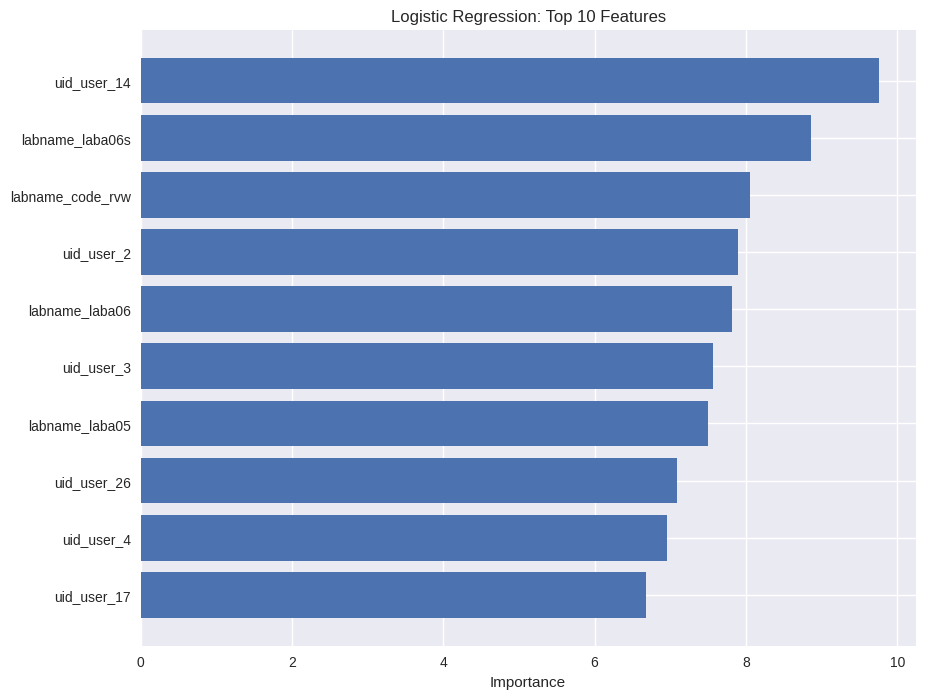

In [15]:
plot_feature_importance(importance, X.columns, 'Logistic Regression')

### b. SVC

1. Train a `SVC` model, for the baseline model use parameters `kernel='linear'`, `probability=True`, `random_state=21`. 
2. Try different kernels, calculate the accuracies.
3. Draw a plot (`barh`) for the baseline model with top-10 most important features (absolute value) for the trained model for the linear kernel *

*By default SVC uses “one vs one” strategy of the classification, thus in `coef_` it returns a matrix. To calculate importance for a feature you need to use [OneVsRestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html) over the SVC and sum all the individual feature importances for all the target values.

In [16]:
svc = OneVsRestClassifier(SVC(kernel='linear', probability=True, random_state=21))
svc.fit(X, y)

,"estimator estimator: estimator objectA regressor or a classifier that implements :term:`fit`.When a classifier is passed, :term:`decision_function` will be usedin priority and it will fallback to :term:`predict_proba` if it is notavailable.When a regressor is passed, :term:`predict` is used.",SVC(kernel='l...ndom_state=21)
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation: the `n_classes`one-vs-rest problems are computed in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: 0.20 `n_jobs` default changed from 1 to None",None
,"verbose verbose: int, default=0The verbosity level, if non zero, progress messages are printed.Below 50, the output is sent to stderr. Otherwise, the output is sentto stdout. The frequency of the messages increases with the verbositylevel, reporting all iterations at 10. See :class:`joblib.Parallel` formore details... versionadded:: 1.1",0
,"C C: float, default=1.0Regularization parameter. The strength of the regularization isinversely proportional to C. Must be strictly positive. The penaltyis a squared l2 penalty. For an intuitive visualization of the effectsof scaling the regularization parameter C, see:ref:`sphx_glr_auto_examples_svm_plot_svm_scale_c.py`.",1.0
,"kernel kernel: {'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'} or callable, default='rbf'Specifies the kernel type to be used in the algorithm. Ifnone is given, 'rbf' will be used. If a callable is given it is used topre-compute the kernel matrix from data matrices; that matrix should bean array of shape ``(n_samples, n_samples)``. For an intuitivevisualization of different kernel types see:ref:`sphx_glr_auto_examples_svm_plot_svm_kernels.py`.",'linear'
,"degree degree: int, default=3Degree of the polynomial kernel function ('poly').Must be non-negative. Ignored by all other kernels.",3
,"gamma gamma: {'scale', 'auto'} or float, default='scale'Kernel coefficient for 'rbf', 'poly' and 'sigmoid'.- if ``gamma='scale'`` (default) is passed then it uses 1 / (n_features * X.var()) as value of gamma,- if 'auto', uses 1 / n_features- if float, must be non-negative... versionchanged:: 0.22 The default value of ``gamma`` changed from 'auto' to 'scale'.",'scale'
,"coef0 coef0: float, default=0.0Independent term in kernel function.It is only significant in 'poly' and 'sigmoid'.",0.0
,"shrinking shrinking: bool, default=TrueWhether to use the shrinking heuristic.See the :ref:`User Guide `.",True
,"probability probability: bool, default=FalseWhether to enable probability estimates. This must be enabled priorto calling `fit`, will slow down that method as it internally uses5-fold cross-validation, and `predict_proba` may be inconsistent with`predict`. Read more in the :ref:`User Guide `.",True
,"tol tol: float, default=1e-3Tolerance for stopping criterion.",0.001


In [17]:
pred = svc.predict(X)
acc = accuracy_score(y, pred)
print(f"SVC Accuracy: {acc:.2f}")

SVC Accuracy: 0.61


In [18]:
importance = np.sum([np.abs(est.coef_[0]) for est in svc.estimators_], axis=0)


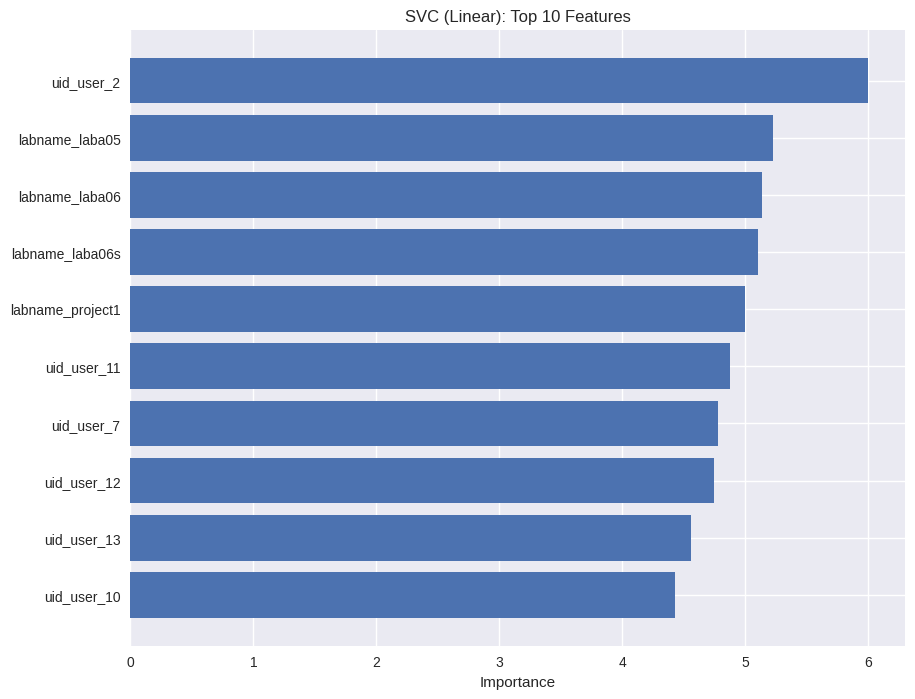

In [19]:
plot_feature_importance(importance, X.columns, 'SVC (Linear)')

### c. Decision tree

1. Train a `DecisionTreeClassifier` using for the baseline model `max_depth=4`, `random_state=21`. 
2. Try different values of `max_depth`, calculate the accuracies.
3. Draw a plot (`barh`) for the baseline model with top-10 most important features (absolute value) for the trained model using the written function.

In [20]:
tree = DecisionTreeClassifier(max_depth=4, random_state=21)
tree.fit(X, y)

pred = tree.predict(X)
acc = accuracy_score(y, pred)
print(f"Decision Tree Accuracy: {acc:.2f}")

Decision Tree Accuracy: 0.55


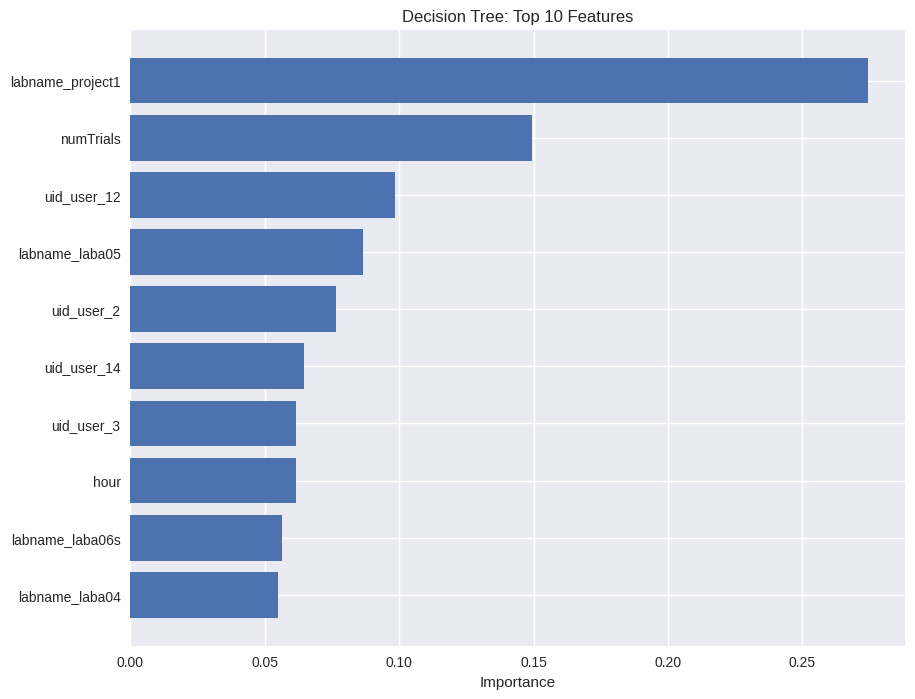

In [21]:
plot_feature_importance(tree.feature_importances_, X.columns, 'Decision Tree')

### d. Random forest

In real life forest is a set of trees. The same thing is with machine learning. Random forest is a set of individual decision trees (check the documentation for more details).

1. Train a `RandomForestClassifier` using for the baseline model parameters `n_estimators=100`, `max_depth = 25`, `random_state=21`. 
2. Try different values of `max_depth` and `n_estimators`, calculate the accuracies.
3. Draw a plot (`barh`) for the baseline model with top-10 most important features (absolute value) for the trained model using the written function.

In [22]:
rf = RandomForestClassifier(n_estimators=100, max_depth=25, random_state=21)
rf.fit(X, y)

pred = rf.predict(X)
acc = accuracy_score(y, pred)
print(f"Random Forest Accuracy: {acc:.2f}")


Random Forest Accuracy: 1.00


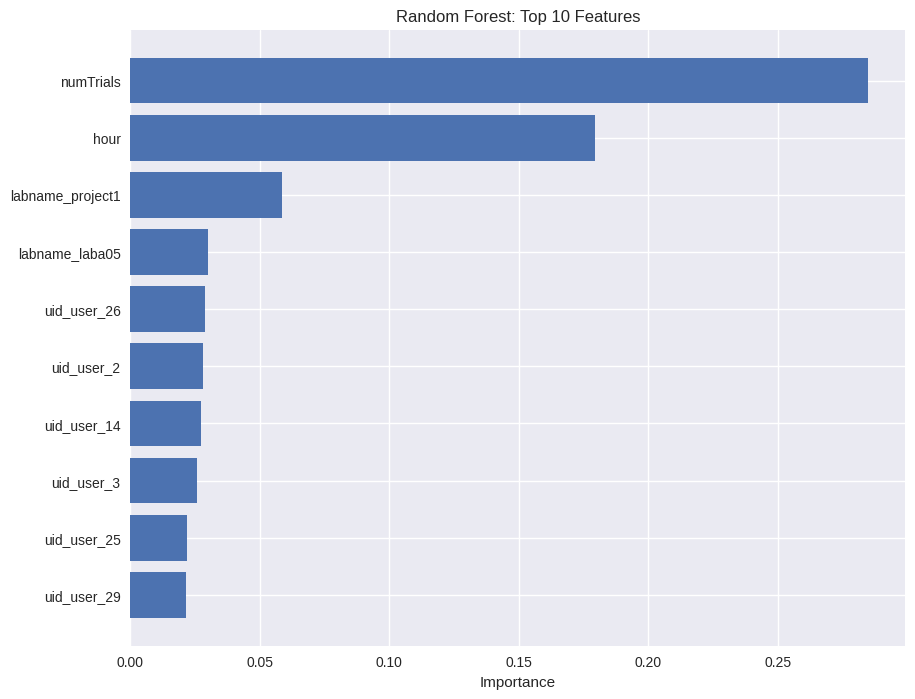

In [23]:
plot_feature_importance(rf.feature_importances_, X.columns, 'Random Forest')